# Robust Controller Design for Generic Orbital Rocket

##### The goal of this project is to develop a robust controller for a small rocket considering a thrust vector control and cannards control. This project is the final project of Control Systems graduate course from EESC-USP. 

#### 1 - Define the rocket parameters

In [143]:
m = 50 # [kg] mass of the rocket
L = 5 # [m] length of the rocket
d = 0.3 # [m] diameter of the rocket
S = 3.14*d**2/2 # [m2] reference area
COM = 3.5 # [m] Center of Moment position from the nose
I = 208.33 # [kg.m^2] Moment of Inertia
T = 1500 # [N] Thrust
g = 9.8 # [m.s^-2] gravity
TW = T/(m*g)
CL_alpha = 4 # [rad^-1] 
CD = 0.2
Cm_alpha = -0.8 # [rad^-1]
tvc_angle = 10 # +-[°] TVC deflection angle
tvc_tal = 0.2 # [s] TVC actuator time constant

bc = 0.3 # [m] canard span
cc = 0.15 # [m] canard chord
ARc = bc**2/(bc*cc) # canard aspect ratio
Sc = bc*cc # canard area
dc = 0.65*L # [m] canard distance from COM

CLc_alpha = 2*3.14*(ARc/(ARc+2)) # [rad^-1] canard lift coefficient gradient
CDc_zero = 0.015 #
k = 0.06
CDc = CDc_zero + k*CLc_alpha**2
CMc = - CLc_alpha *dc/L # [rad^-1] canard moment contribution
canard_angle = 15 # +-[°] canard deflection angle
canard_tal = 0.2 # [s] canard actuator time constant

### 2 - Rocket's Equations of Motion

Simplified Forces Diagram in the Rocket:
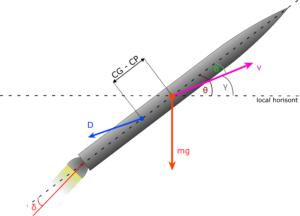

#### 2.1 - Translational Equations
##### Longitudinal axis (x):
$\dot{u} = \frac{1}{m} \left(T\cos{\delta_{TVC}} + L_c \sin{\alpha_c} - D_c\cos{\alpha_c} + L\sin{\alpha} - D\cos{\alpha}\right) - g\sin{\gamma} + qv$
##### Vertical axis (y):
$\dot{v} = \frac{1}{m} \left( T\sin{\delta_{TVC}} - L_c \cos{\alpha_c} - D_c\sin{\alpha_c} - L\cos{\alpha} - D\sin{\alpha}\right) + g\cos{\gamma} + qu$

##### Kinematic relations:
$\dot{x} = u\cos{\gamma} - v\sin{\gamma},\ \ \dot{y} = - u\sin{\gamma}  -v\cos{\gamma}$
#### 2.2 - Rotational Dynamics
##### Canard Moment generated by drag:
$M_{D_c} = D_c \cdot d_c$

##### Pitch rate $(q)$:
$\dot{q} = \frac{1}{I} \left( M_{TVC} + M_{L_c} + M_a - M_{D_c} \right)$
##### Pitch angle $(\theta)$: 
$\dot{\theta} = q$
#### 2.3 - Kinematic Equations
##### Horizontal position $(x)$:
$\dot{x} = u\cos{\theta} - v\sin{\theta}$
##### Vertical position $(y)$:
$\dot{y} = u\sin{\theta} + v\cos{\theta}$
#### 2.4 - Forces and Moments Definitions
##### Thrust Force Components:
$T\cos{\delta_{TVC}}, \ \ T\sin{\delta_{TVC}}, \\
M_T = T\sin{\delta_{TVC}}\cdot d_{TVC}$
##### Canard Lift and Drag:
$F_{D_c} = \frac{1}{2}\rho V^2S_cC_{D_c}, \ F_{L_c} = \frac{1}{2}\rho V^2S_cC_{L_c} \\
M_{L_c} = F_{L_c} \cdot d_c, \ M_{D_c} = F_{D_c} \cdot d_c $
##### Body Aerodynamic Forces:
$L = \frac{1}{2}\rho V^2S_cC_{L}, \ D = \frac{1}{2}\rho V^2S_cC_{D} $
##### Aerodynamic Pitching Moment:
$M_a = \frac{1}{2}\rho V^2S_c C_{m} c$
### 3 - State Space Model
#### 3.1 - Nominal Model
The nominal model is:  
$\dot{x} = Ax + Bu_{in} + Gd$  
where $x \ = \ [u,v,q,\theta,x,y]^{T} \ , \ u_{in} = [T, \delta_{TVC}, \alpha_c]^{T} \,\ d=[\Delta T, \Delta \delta_{TVC}, \Delta C_L, \Delta C_D]^{T}$  
$ y = Cx + Du$  
where the chosen outputs are $y \ = \ [u,q,\theta,y]^{T}$

#### Calculating the Matrices using symbolic library Sympy

In [144]:
import sympy as sp
import numpy as np

# Define symbolic variables
# States
u, v, q, theta, x, y = sp.symbols('u v q theta x y')

# Inputs
Thurst, delta_TVC, alpha_c = sp.symbols('Thurst delta_TVC alpha_c')

# Disturbances
Delta_T, Delta_delta_TVC, Delta_C_L, Delta_C_D = sp.symbols('Delta_T Delta_delta_TVC Delta_C_L Delta_C_D')

d = sp.Matrix([Delta_T, Delta_delta_TVC, Delta_C_L, Delta_C_D])

# Parameters
mass, gravity, InertiaM, rho, A, S_c, C_D_c, C_L_c, C_D, C_L, C_m, d_c, d_TVC = sp.symbols('m g I rho S S_c C_D_c C_L_c C_D C_L C_m d_c d_TVC')

# Derived quantities
V = sp.sqrt(u**2 + v**2)  # Total velocity

# Aerodynamic forces (canard and body)
F_D_c = 0.5 * rho * V**2 * S_c * C_D_c
F_L_c = 0.5 * rho * V**2 * S_c * C_L_c
F_D = 0.5 * rho * V**2 * A * C_D
F_L = 0.5 * rho * V**2 * A * C_L

# Moments
M_TVC = Thurst * sp.sin(delta_TVC) * d_TVC
M_L_c = F_L_c * d_c
M_D_c = F_D_c * d_c
M_a = 0.5 * rho * V**2 * A * C_m

# State vector
x_vec = sp.Matrix([u, v, q, theta, x, y])

# Define intermediate variable
alpha_eff = sp.Symbol('alpha_eff')
alpha = sp.atan(v/u)

# Effective angle of attack
alpha_eff_eq = sp.Eq(alpha_eff, alpha_c + alpha)


du_dt = (1 / m) * (Thurst * sp.cos(delta_TVC) + F_L_c * sp.sin(alpha_eff) - F_D_c * sp.cos(alpha_eff) + F_L * sp.sin(alpha) - F_D * sp.cos(alpha)) - gravity * sp.sin(theta) + q * v
dv_dt = (1 / m) * (Thurst * sp.sin(delta_TVC) - F_L_c * sp.cos(alpha_eff) - F_D_c * sp.sin(alpha_eff) - F_L * sp.cos(alpha) - F_D * sp.sin(alpha)) + gravity * sp.cos(theta) - q * u

# Rotational equations
dq_dt = (1 / InertiaM) * (M_TVC + M_L_c + M_a - M_D_c)

dtheta_dt = q

# Kinematic equations (position)
dx_dt = u * sp.cos(theta) - v * sp.sin(theta)
dy_dt = u * sp.sin(theta) + v * sp.cos(theta)

# Assemble the state equations
f = sp.Matrix([du_dt, dv_dt, dq_dt, dtheta_dt, dx_dt, dy_dt])

# Inputs vector
u_in = sp.Matrix([Thurst, delta_TVC, alpha_c])

# Output vector
y_out = sp.Matrix([u, q, theta, y])

# Forces with uncertainty
F_x = (Thurst + Delta_T) * sp.cos(delta_TVC + Delta_delta_TVC) - (C_D + Delta_C_D) * (0.5 * rho * V**2 * A)
F_y = (Thurst + Delta_T) * sp.sin(delta_TVC + Delta_delta_TVC) - (C_L + Delta_C_L) * (0.5 * rho * V**2 * A)

# Define uncertainty matrix G
G = sp.Matrix([
    [F_x.diff(Delta_T), F_x.diff(Delta_delta_TVC), F_x.diff(Delta_C_L), F_x.diff(Delta_C_D)],  # Effect on u-dot
    [F_y.diff(Delta_T), F_y.diff(Delta_delta_TVC), F_y.diff(Delta_C_L), F_y.diff(Delta_C_D)],  # Effect on v-dot
    [0, 0, 0, 0],  # Effect on q-dot (rotational dynamics)
    [0, 0, 0, 0],  # Effect on theta-dot (orientation dynamics)
    [0, 0, 0, 0],  # Effect on x-dot (position x)
    [0, 0, 0, 0]   # Effect on y-dot (position y)
])


# Compute the Jacobians
A = f.jacobian(x_vec)  # Partial derivatives of f with respect to states
B = f.jacobian(u_in)  # Partial derivatives of f with respect to inputs
C = y_out.jacobian(x_vec) # Partial derivatives of outputs w.r.t. states
D = y_out.jacobian(u_in)   # Partial derivatives of outputs w.r.t. inputs

#### Run the cell below to display the symbolic matrices

In [145]:
# Display results
print("Matrix A:")
sp.pprint(A)

print("\nMatrix B:")
sp.pprint(B)

print("\nMatrix C:")
sp.pprint(C)

print("\nMatrix D:")
sp.pprint(D)

print("\nMatrix G:")
sp.pprint(G)

Matrix A:
⎡                                   2 ⎛ 2    2⎞                                ↪
⎢    0.02⋅C_D⋅S⋅ρ⋅u   0.01⋅C_D⋅S⋅ρ⋅v ⋅⎝u  + v ⎠                                ↪
⎢  - ────────────── - ───────────────────────── - 0.02⋅C_D_c⋅S_c⋅ρ⋅u⋅cos(α_eff ↪
⎢          ________                   3/2                                      ↪
⎢         ╱      2            ⎛     2⎞                                         ↪
⎢        ╱      v           3 ⎜    v ⎟                                         ↪
⎢       ╱   1 + ──         u ⋅⎜1 + ──⎟                                         ↪
⎢      ╱         2            ⎜     2⎟                                         ↪
⎢    ╲╱         u             ⎝    u ⎠                                         ↪
⎢                                                                              ↪
⎢                                  ⎛ 2    2⎞                 3 ⎛ 2    2⎞       ↪
⎢  0.02⋅C_D⋅S⋅ρ⋅v   0.01⋅C_D⋅S⋅ρ⋅v⋅⎝u  + v ⎠   0.01⋅C_D⋅S⋅ρ⋅v ⋅⎝u  + v ⎠       ↪
⎢- ────────────── 

#### Define the model initial conditions

In [146]:
u = 300 # Longitudinal velocity (m/s)
v = 75
q = 0.5
theta = np.deg2rad(5)
x = 1000
y = 5000
rho = 1.225
# T
dTVC = np.deg2rad(10)
alpha_c = np.deg2rad(8)
DT = 0.05*T
DdTVC = 0.1*dTVC
alpha = np.atan(v/u)
CL = CL_alpha*alpha
DCL = 0.05*CL
DCD = 0.05*CD
Cm = Cm_alpha*alpha
d_TVC = L
alpha_eff = alpha_c + alpha 
CLc = CLc_alpha*alpha_eff
CDc = CDc_zero

#### Asign values to symbolic variables

In [147]:
numerical_values = {
    sp.Symbol('u'): u,  
    sp.Symbol('v'): v,  
    sp.Symbol('q'): q,  
    sp.Symbol('theta'): theta,  
    sp.Symbol('x'): x,
    sp.Symbol('y'): y,
    sp.Symbol('Thurst'): T,  
    sp.Symbol('delta_TVC'): dTVC,  
    sp.Symbol('alpha_c'): alpha_c,  
    sp.Symbol('Delta_T'): DT,  
    sp.Symbol('Delta_delta_TVC'): DdTVC,  
    sp.Symbol('Delta_C_L'): DCL,  
    sp.Symbol('Delta_C_D'): DCD,  
    sp.Symbol('m'): m,  
    sp.Symbol('g'): g,  
    sp.Symbol('I'): I,  
    sp.Symbol('rho'): rho,  
    sp.Symbol('S'): S,  
    sp.Symbol('S_c'): Sc,  
    sp.Symbol('C_D_c'): CDc,  
    sp.Symbol('C_L_c'): CLc,  
    sp.Symbol('C_D'): CD,  
    sp.Symbol('C_L'): CL,  
    sp.Symbol('C_m'): Cm,  
    sp.Symbol('d_c'): dc,  
    sp.Symbol('d_TVC'): d_TVC,  
    sp.Symbol('alpha_eff'): alpha_eff,  
}

In [148]:
A_eval = np.array(A.subs(numerical_values).evalf()).astype(np.float64)
print("Evaluated A matrix:")
print(A_eval)

Evaluated A matrix:
[[ 6.08730745e-02  1.06648935e+00  7.50000000e+01 -9.76270804e+00
   0.00000000e+00  0.00000000e+00]
 [-1.91546645e+00 -3.29791378e-01 -3.00000000e+02 -8.54126279e-01
   0.00000000e+00  0.00000000e+00]
 [ 2.58843084e-01  6.47107711e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.96194698e-01 -8.71557427e-02  0.00000000e+00 -1.00861325e+02
   0.00000000e+00  0.00000000e+00]
 [ 8.71557427e-02  9.96194698e-01  0.00000000e+00  2.92321729e+02
   0.00000000e+00  0.00000000e+00]]


In [149]:
B_eval = np.array(B.subs(numerical_values).evalf()).astype(np.float64)
C_eval = np.array(C.evalf()).astype(np.float64)
D_eval = np.array(D.evalf()).astype(np.float64)
G_eval = np.array(G.subs(numerical_values).evalf()).astype(np.float64)

### Creating the State Space Model

In [150]:
import os
import control as ctrl
import matplotlib.pyplot as plt

# Augmenting B to include uncertainty/disturbances as inputs
B_total = np.hstack((B_eval, G_eval))  # Combine input and disturbance matrices -> u_new = [u(0) u(1) u(2) d(0) d(1) d(2) d(3)]
# Update D matrix accordingly
D_eval_new = np.zeros((4, 7))

# Define the state-space system
sys = ctrl.ss(A_eval, B_total, C_eval, D_eval_new)
print("State-Space System:")
print(sys)

State-Space System:
<StateSpace>: sys[236]
Inputs (7): ['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]', 'u[5]', 'u[6]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 6.08730745e-02  1.06648935e+00  7.50000000e+01 -9.76270804e+00
       0.00000000e+00  0.00000000e+00]
     [-1.91546645e+00 -3.29791378e-01 -3.00000000e+02 -8.54126279e-01
       0.00000000e+00  0.00000000e+00]
     [ 2.58843084e-01  6.47107711e-02  0.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00]
     [ 9.96194698e-01 -8.71557427e-02  0.00000000e+00 -1.00861325e+02
       0.00000000e+00  0.00000000e+00]
     [ 8.71557427e-02  9.96194698e-01  0.00000000e+00  2.92321729e+02
       0.00000000e+00  0.00000000e+00]]

B = [[ 1.96961551e-02 -5.20944533e+00  0.00000000e+00  9.81627183e-01
      -3.00524168e+02  0.00000000e+00 -8.27598516e+03]

#### Step Response Calculation

In [151]:
time, response = ctrl.step_response(sys)

# Time vector for step response simulation
time = np.linspace(0, 10, 500)

# Number of inputs and outputs
n_inputs = B_total.shape[1]
n_outputs = C_eval.shape[0]

# Create directory for saving responses if it doesn't exist
output_dir = "responses"
os.makedirs(output_dir, exist_ok=True)

# Define labels for inputs and outputs
input_labels = ["Thrust", "TVC Angle", "Canard Angle", "Delta Thrust", "Delta TVC Angle", "Delta CL", "Delta CD"]
output_labels = ["u", "q", "Theta", "y"]

# Create a separate plot for each input-output pair
for i in range(n_inputs):  # Iterate over inputs
    for j in range(n_outputs):  # Iterate over outputs
        # Compute step response for input i
        t, response = ctrl.step_response(sys, input=i, T=time)
        
        # Create figure for this pair
        plt.figure(figsize=(10,10))
        plt.plot(t, response[j, :].T, label=f"{output_labels[j]} due to {input_labels[i]}")
        plt.title(f"Step Response: {input_labels[i]} → {output_labels[j]}")
        plt.xlabel("Time (s)")
        plt.ylabel("Response")
        plt.grid(True)
        plt.legend()
        
        # Save the figure in the responses directory
        filename = os.path.join(output_dir, f"step_response_{input_labels[i]}_{output_labels[j]}.png")
        plt.savefig(filename)
        plt.close()  # Close the plot to avoid overlapping plots in memory

d:\miniconda\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
d:\miniconda\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
d:\miniconda\Lib\site-packages\control\timeresp.py:1199: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


#### The figures are saved in a folder called *responses* in the directory of the notebook.

#### Testing a LQR Controller

In [152]:
# Define weighting matrices
Q = np.diag([300, 300, 50, 80, 5, 5])  # Penalize state deviations
R = np.diag([1, 5, 5])   # Penalize control effort

# Compute LQR gain matrix
K, S, E = ctrl.lqr(A_eval, B_eval, Q, R)

# Closed-loop system (A - B*K)
A_cl = A_eval - B_eval @ K
sys_cl = ctrl.ss(A_cl, B_eval, C_eval, D_eval)

# Simulate the step response
time = np.linspace(0, 10, 500)
time, response = ctrl.step_response(sys_cl, T=time)

# Create directory for saving responses if it doesn't exist
output_dir = "responses-lqr"
os.makedirs(output_dir, exist_ok=True)

# Number of inputs and outputs
n_inputs = B_eval.shape[1]
n_outputs = C_eval.shape[0]

# Define labels for inputs and outputs
input_labels = ["Thrust", "TVC Angle", "Canard Angle"]
output_labels = ["u", "q", "Theta", "y"]

# Create a separate plot for each input-output pair
for i in range(n_inputs):  # Iterate over inputs
    for j in range(n_outputs):  # Iterate over outputs
        # Compute step response for input i
        t, response = ctrl.step_response(sys_cl, input=i, T=time)
        
        # Create figure for this pair
        plt.figure(figsize=(10,10))
        plt.plot(t, response[j, :].T, label=f"{output_labels[j]} due to {input_labels[i]}")
        plt.title(f"LQR - Step Response: {input_labels[i]} → {output_labels[j]}")
        plt.xlabel("Time (s)")
        plt.ylabel("Response")
        plt.grid(True)
        plt.legend()
        
        # Save the figure in the responses directory
        filename = os.path.join(output_dir, f"LQR-step_response_{input_labels[i]}_{output_labels[j]}.png")
        plt.savefig(filename)
        plt.close()  # Close the plot to avoid overlapping plots in memory

#### The figures are saved in a folder called *responses-lqr* in the directory of the notebook.

#### Evaluating the system response due to uncertainty/disturbances using the LQR controller

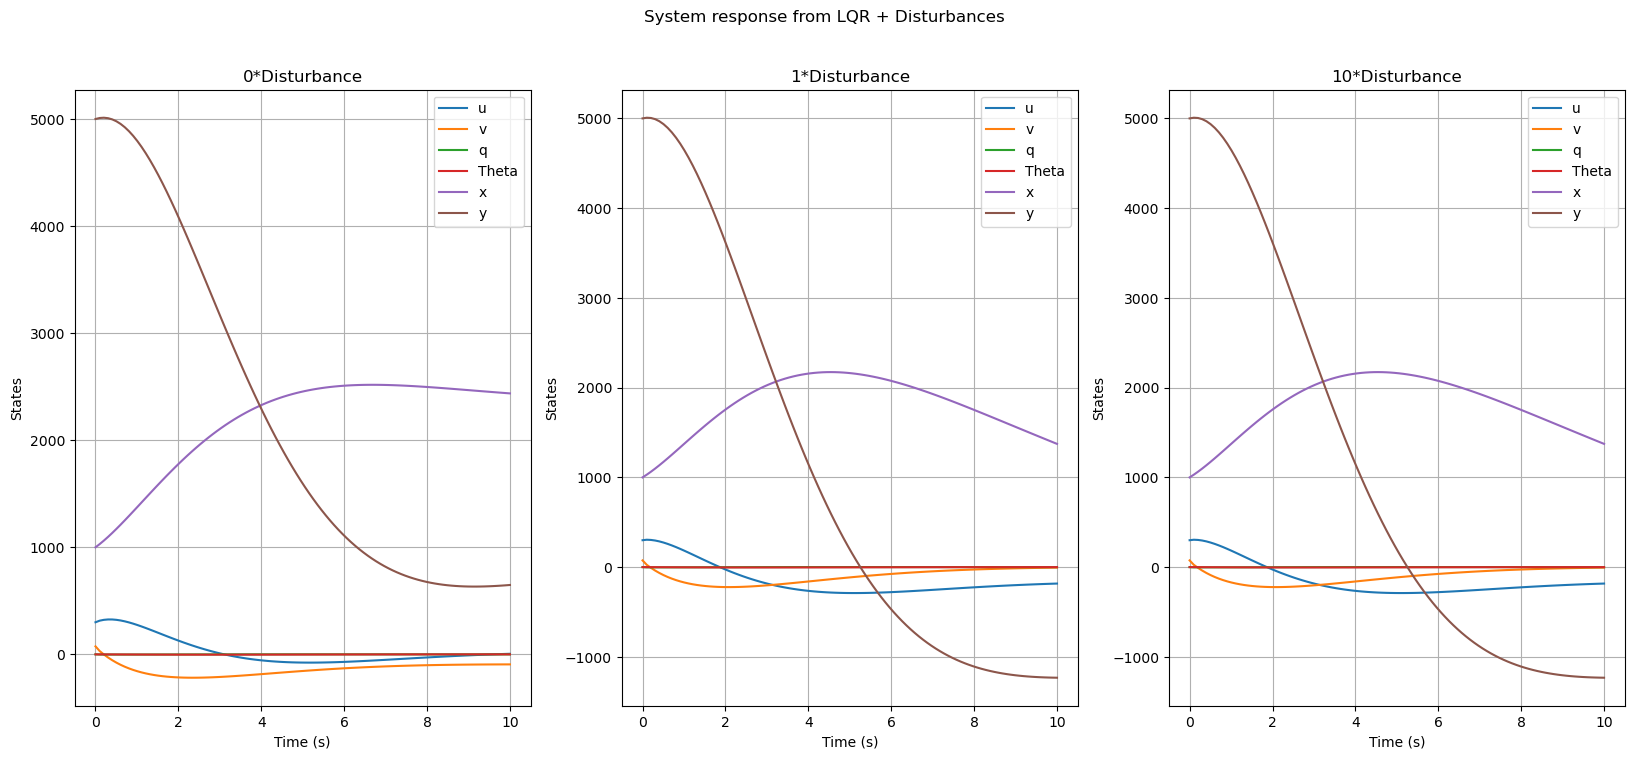

In [153]:
from scipy.integrate import solve_ivp

# Define the disrturbances
def disturbance(t):
    return np.array([DT, DdTVC, DCL, DCD])  

# Systems dynamics
def dynamics(t, x, n):
    d = disturbance(t)
    u = -K @ x  # LQR Controller
    dxdt = A_cl @ x + G_eval @ (n*d)  # Full dynamics
    return dxdt

# Initial conditions
x0 = np.array([u, v, q, theta, x, y])
n = 1

# Solve ODE
t_span = (0, 10)
t_eval = np.linspace(*t_span, 100)
sol0 = solve_ivp(dynamics, t_span, x0, t_eval=t_eval, args=(0,))
sol1 = solve_ivp(dynamics, t_span, x0, t_eval=t_eval, args=(1,))
sol10 = solve_ivp(dynamics, t_span, x0, t_eval=t_eval, args=(10,))

plt.figure(figsize=(20,8))

plt.subplot(131)
plt.plot(sol0.t, sol0.y.T)
plt.xlabel("Time (s)")
plt.ylabel("States")
plt.legend(["u", "v", "q", "Theta", "x", "y"])
plt.title("0*Disturbance")
plt.grid()

plt.subplot(132)
plt.plot(sol1.t, sol1.y.T)
plt.xlabel("Time (s)")
plt.ylabel("States")
plt.legend(["u", "v", "q", "Theta", "x", "y"])
plt.title("1*Disturbance")
plt.grid()

plt.subplot(133)
plt.plot(sol1.t, sol1.y.T)
plt.xlabel("Time (s)")
plt.ylabel("States")
plt.legend(["u", "v", "q", "Theta", "x", "y"])
plt.title("10*Disturbance")
plt.grid()

plt.suptitle("System response from LQR + Disturbances")
plt.show()

##### As can be seen from the previous plot, the level of disturbance/uncertainty does not impact the behavior of rocket's velocity and orientation, which are the most relevant parameters for orbital rockets during initial phases of launch.

#### Calculating the eigenvalues of the system

In [154]:
import scipy.linalg as la

eigenvalue, eigenvectors = la.eig(A_cl)
print(eigenvalue.real)

[-2.43162514e+02 -2.43162514e+02 -1.19523133e+00 -3.52564156e-01
 -3.52564156e-01 -2.73607421e-03]


##### As the real part of all eigenvalues are negative, then the system is stable.